In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [9]:
API_KEY = "c5bd29738abd9683d647559a1c9af387f89daf79c68df4c5d7e3ea92344ab2b7aff159ab6e6f47cd324b309c27bef547e5a5194a29b11b438e0d37a0129f122f"

In [11]:
service = QiskitRuntimeService(channel="ibm_quantum", token=API_KEY, instance="pinq-quebec-hub/univ-toronto/matterlab")

In [13]:
# Save account to disk.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token=API_KEY,
    instance="pinq-quebec-hub/univ-toronto/matterlab",
    name="ibm_uoft",
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)




In [7]:
# Load saved credentials
service = QiskitRuntimeService(name="ibm_uoft")
back_end = "ibm_quebec"

# QCBM 


In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
import numpy as np

class QCBMAnsatz:
    def __init__(self, num_qubits, depth):
        self.num_qubits = num_qubits
        self.depth = depth
        self.params = [Parameter(f'theta_{i}') for i in range(num_qubits * depth)]
        self.qc = QuantumCircuit(num_qubits, num_qubits)  # Add classical bits
        self._build_circuit()

    def _build_circuit(self):
        param_idx = 0
        for _ in range(self.depth):
            for qubit in range(self.num_qubits):
                self.qc.ry(self.params[param_idx], qubit)
                param_idx += 1
            for qubit in range(self.num_qubits - 1):
                self.qc.cx(qubit, qubit + 1)
        self.qc.measure(range(self.num_qubits), range(self.num_qubits))  # Add measurements

    def get_executable_circuit(self, parameters, backend):
        param_dict = {self.params[i]: parameters[i] for i in range(len(self.params))}
        qc_copy = self.qc.copy()
        qc_copy.assign_parameters(param_dict, inplace=True)
        # Transpile the circuit for the specific backend
        transpiled_circuit = transpile(qc_copy, backend=backend)
        return transpiled_circuit


In [2]:
from scipy.optimize import minimize

class ScipyOptimizer:
    def __init__(self, method='COBYLA', options=None):
        self.method = method
        self.options = options if options else {}

    def minimize(self, loss_fn, initial_params):
        result = minimize(loss_fn, initial_params, method=self.method, options=self.options)
        return result


In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
import numpy as np

class SingleBasisQCBM:
    def __init__(self, ansatz, optimizer, distance_measure=None, choices=(-1.0, 1.0), param_initializer=None):
        self.ansatz = ansatz
        self.optimizer = optimizer
        self.num_qubits = ansatz.num_qubits
        self.distance_measure = distance_measure if distance_measure else self._default_distance_measure
        self.choices = choices
        self.params = self._get_initial_parameters(param_initializer)

    def _default_distance_measure(self, target_probs, model_probs):
        epsilon = 1e-10
        return np.sum(target_probs * np.log(target_probs / (model_probs + epsilon) + epsilon))

    def _get_initial_parameters(self, initializer):
        if initializer:
            return initializer(self.ansatz.num_qubits * self.ansatz.depth)
        return np.random.uniform(-np.pi / 2, np.pi / 2, self.ansatz.num_qubits * self.ansatz.depth)

    def _get_model_object(self, parameters, sampler, backend):
        qc = self.ansatz.get_executable_circuit(parameters, backend)
        job = sampler.run(circuits=[qc])
        result = job.result()
        quasi_dist = result.quasi_dists[0]
        counts = quasi_dist.binary_probabilities()
        shots = sum(counts.values())
        probs = np.array([counts.get(f"{i:0{self.num_qubits}b}", 0) / shots for i in range(2**self.num_qubits)])
        return probs

    def _get_generator_fn(self, sampler, backend, random_seed=None):
        def generator(n_samples, parameters):
            qc = self.ansatz.get_executable_circuit(parameters, backend)
            job = sampler.run(circuits=[qc])
            result = job.result()
            quasi_dist = result.quasi_dists[0]
            counts = quasi_dist.binary_probabilities()
            samples = np.array([list(map(int, k)) for k, v in counts.items() for _ in range(int(v * n_samples))])
            return samples
        return generator

    def train_on_batch(self, X, Y, sampler, backend, n_epochs):
        target_probs = np.zeros(2**self.num_qubits)
        for x, y in zip(X, Y):
            index = int("".join(map(str, x)), 2)
            target_probs[index] = y

        for epoch in range(n_epochs):
            def loss_fn(parameters):
                model_probs = self._get_model_object(parameters, sampler, backend)
                return self.distance_measure(target_probs, model_probs)

            result = self.optimizer.minimize(loss_fn, self.params)
            self.params = result.x
        return result

    def generate(self, num_samples, sampler, backend):
        generator = self._get_generator_fn(sampler, backend)
        samples = generator(num_samples, self.params)
        unique_samples, counts = np.unique(samples, axis=0, return_counts=True)
        probabilities = counts / num_samples
        return unique_samples, probabilities

# Define an example of creating and training a SingleBasisQCBM
# Initialize Qiskit Runtime Service with specific credentials
service = QiskitRuntimeService(name="ibm_uoft")
backend = service.backend("ibm_quebec")  # Using IBM Quebec backend

num_qubits = 3
depth = 2
X = np.array([[1, 1, 1], [0, 1, 1]])
Y = np.array([0.2, 0.8])

ansatz = QCBMAnsatz(num_qubits, depth)

options = {
    'maxiter': 1,   # Maximum number of iterations
    'tol': 1e-6,      # Tolerance for termination
    'disp': True      # Display convergence messages
}

optimizer = ScipyOptimizer(method='COBYLA', options=options)

qcbm = SingleBasisQCBM(ansatz, optimizer)

n_epochs = 1

# Start a session
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    result = qcbm.train_on_batch(X, Y, sampler, backend, n_epochs)
    num_samples = 1000
    unique_samples, probabilities = qcbm.generate(num_samples, sampler, backend)
    for sample, prob in zip(unique_samples, probabilities):
        print(f"Sample: {sample}, Probability: {prob}")







/var/folders/01/9cxlhzln35j3j4d6wdv8jmmw0000gp/T/ipykernel_11117/1503305846.py:91: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)



   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =    1   F = 4.295104E+00    MAXCV = 0.000000E+00
   X =-1.548493E+00  -3.167899E-02  -1.243793E+00   2.935643E-01  -3.371391E-01
       9.544549E-01
Sample: [0 0 0], Probability: 0.468
Sample: [0 0 1], Probability: 0.275
Sample: [0 1 0], Probability: 0.002
Sample: [0 1 1], Probability: 0.007
Sample: [1 0 0], Probability: 0.011
Sample: [1 0 1], Probability: 0.087
Sample: [1 1 0], Probability: 0.064
Sample: [1 1 1], Probability: 0.082


In [18]:
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    samples = qcbm.generate(num_samples, sampler, backend)
    print(samples)

/var/folders/01/9cxlhzln35j3j4d6wdv8jmmw0000gp/T/ipykernel_2727/3958206110.py:2: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)


[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [1 1 1]
 [1 1 1]
 [1 1 1]]


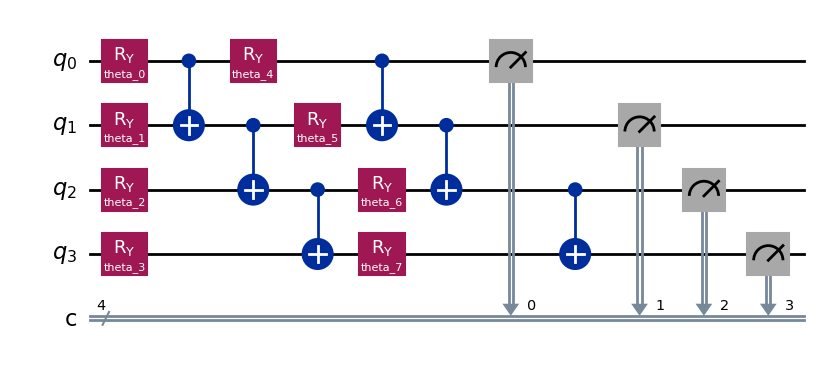

In [6]:
ansatz = QCBMAnsatz(4, 2)
ansatz.qc.draw(output="mpl")